# Evaluating similarity of example sentences

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Installation of bert-as-service is needed. Check https://github.com/hanxiao/bert-as-service
# This notebook uses the LARGE Cased pre-trained BERT model: cased_L-24_H-1024_A-16

# First, start bert-as-service server separately

# Then connect to bert-as-service server
from bert_serving.client import BertClient
bc = BertClient()

In [2]:
# Check that connection to server works
test = bc.encode(['This is a test sentence'])
test

array([[ 0.20245346, -0.07067921,  0.12692763, ...,  0.6660406 ,
         0.12261808,  0.05835291]], dtype=float32)

In [3]:
sentences = ['I like my phone',
             'Your cellphone looks great.', 
             'Will it snow tomorrow?', 
             'Hurricanes have hit the US',
             'How old are you?', 
             'what is your age?']
sentences_vecs = bc.encode(sentences)

In [4]:
len_sentences = len(sentences)
sim_matrix = np.zeros([len_sentences, len_sentences])
for idx in range(len(sentences)):
    for idy in range(idx,len_sentences):
        score = np.dot(sentences_vecs[idx], sentences_vecs[idy]) / np.linalg.norm(sentences_vecs[idx]) / np.linalg.norm(sentences_vecs[idy])
        #print("ID: {}, sentence1: {}, sentence2: {}".format(idx, sentences[idx], sentences[idy]))
        sim_matrix[idx, idy] = score
        sim_matrix[idy, idx] = score

### We can compare the calculated similarities between each pair of sentences

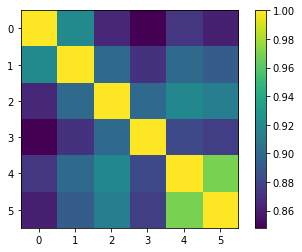

In [100]:
plt.imshow(sim_matrix)
plt.colorbar()

Compare to matrix in Google's blog: https://ai.googleblog.com/2018/05/advances-in-semantic-textual-similarity.html

In [6]:
%%HTML
<img src="https://2.bp.blogspot.com/-9Qk1fubLpzg/Wv2QGgKVVmI/AAAAAAAACvs/Gm-XF3prXVIIvaIkrTmkcIcYz-4qSxLKwCLcBGAs/s1600/image2.png">

Results are not as clear as the ones from Google's report, but this approach is completely unsupervised.

# Evaluating STS-B Sentence similarity Dataset
## http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark

To get a better idea, we can use the same technique to complete the STS-B task (part of GLUE Benchmark)

In [7]:
TASK = 'STS'
assert TASK in ('STS'), 'Only (STS) is demonstrated here.'
# Download glue data.
! test -d dowload_glue_repo || git clone https://gist.github.com/60c2bdb54d156a41194446737ce03e2e.git download_glue_repo
! python download_glue_repo/download_glue_data.py --data_dir='glue_data' --tasks=$TASK
TASK_DATA_DIR = 'glue_data/' + TASK + '-B'
print('***** Task data directory: {} *****'.format(TASK_DATA_DIR))
!ls $TASK_DATA_DIR

Cloning into 'download_glue_repo'...
remote: Enumerating objects: 21, done.
remote: Total 21 (delta 0), reused 0 (delta 0), pack-reused 21
Unpacking objects: 100% (21/21), done.
	Completed!
***** Task data directory: glue_data/STS-B *****
dev.tsv  LICENSE.txt  original	readme.txt  test.tsv  train.tsv


In [29]:
# Get evaluator file. From STS-B readme:
#The official evaluation is the Pearson correlation coefficient. Given
#an output file comprising the system scores (one per line) in a file
#called sys.txt, you can use the evaluation script as follows:
#
#$ perl correlation.pl sts-dev.txt sys.txt
! wget https://raw.githubusercontent.com/rgtjf/Semantic-Texual-Similarity-Toolkits/master/data/stsbenchmark/correlation.pl -O glue_data/STS-B/correlation.pl

--2019-03-25 02:05:17--  https://raw.githubusercontent.com/rgtjf/Semantic-Texual-Similarity-Toolkits/master/data/stsbenchmark/correlation.pl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2119 (2.1K) [text/plain]
Saving to: ‘glue_data/STS-B/correlation.pl’

glue_data/STS-B/cor 100%[===================>]   2.07K  --.-KB/s    in 0s      

2019-03-25 02:05:19 (20.1 MB/s) - ‘glue_data/STS-B/correlation.pl’ saved [2119/2119]



In [91]:
# READ developers set

import csv
"""Reads a tab separated value file."""
input_file = TASK_DATA_DIR + "/dev.tsv"
lines = []
gs_scores = []
with open(input_file, "r") as f:
  reader = csv.reader(f, delimiter="\t", quotechar=None)
  for line in reader:
    lines.append(line[7:9])
    gs_scores.append(line[9])

lines.pop(0) # Get rid of the header
gs_scores.pop(0)
print(lines[0:5]) # Show some examples
gs_scores = [float(value) for value in gs_scores]
print(gs_scores[0:5])

[['A man with a hard hat is dancing.', 'A man wearing a hard hat is dancing.'], ['A young child is riding a horse.', 'A child is riding a horse.'], ['A man is feeding a mouse to a snake.', 'The man is feeding a mouse to the snake.'], ['A woman is playing the guitar.', 'A man is playing guitar.'], ['A woman is playing the flute.', 'A man is playing a flute.']]
[5.0, 4.75, 5.0, 2.4, 2.75]


In [71]:
## CALCULATE BERT untrained similarities

num_pairs = len(lines)
with open("sys.txt", "w") as fo:
    for i in range(num_pairs):
        sent_vecs = bc.encode(lines[i])
        score = np.dot(sent_vecs[0], sent_vecs[1]) / np.linalg.norm(sent_vecs[0]) / np.linalg.norm(sent_vecs[1])
        fo.write(str(score) + '\n')

In [92]:
## READ predicted similarities from file, because I didn't keep them :P
with open("sys.txt", "r") as fs:
    similarities = [float(entry) for entry in fs]

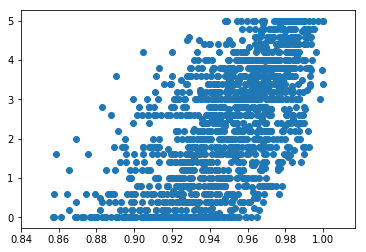

In [94]:
## PLOT human vs predicted similarities

plt.scatter(similarities, gs_scores)

In [99]:
## CALCULATE Pearson and Spearman correlation coefficients

from pydoc import help
from scipy.stats.stats import pearsonr, spearmanr
print("PearsonrResult:{}".format(pearsonr(similarities, gs_scores)))
print(spearmanr(similarities, gs_scores))

PearsonrResult:(0.6258692943475741, 6.52840806337292e-164)
SpearmanrResult(correlation=0.6405689318855184, pvalue=4.944164259270278e-174)


We can compare these results with the benchmark's leaderboard: http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark
According to BERT paper, they did better than anyone in that table after fine-tuning, but their results are not included in the table, so I guess it's not up to date.

I consider we should compare with the test column of the table, as we didn't use the developer's set to tune any parameters at all. If this assumption is valid, this technique offers mid-table unsupervised results. Whether that's enough for our purposes is a different question.